<a href="https://colab.research.google.com/github/raminass/deep-NMF/blob/master/Ongoing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Unconstrained NMF
NMF receives input matrix $V_{(FxN)}$ and number of factors $K$.

And it outputs non-negative matrices $W_{FxK}$, $H_{KxN}$: 

>>>> $V \approx WH$

Solve:

>>>>$\hat{W},\hat{H} = \underset{W\geq0,H\geq0}{\operatorname{argmin}} d_{\beta}(V|WH)$ 


Method

 1.  MU *(Févotte et al., 2009)*:



>>>>$H \gets H \odot \dfrac{W^T[V \odot(WH)^{\beta-2}]}{W^T(WH)^{\beta-1}}$

>>>>$W \gets H \odot \dfrac{W^T[V \odot(WH)^{\beta-2}]}{W^T(WH)^{\beta-1}}$

### Implementation

Our goal is to calculate H while untieing W and learn them as network weights.
We imitate Hersheys idea, but we make it for general beta.

The steps as follows:


1.   obtain training data using any classical/out of the box methods, so for a given $v_i$ sample input we have the corresponding $h_i$  coeffecients vector
2.   We built a layer that unrolled this iteration, the layer structure(forward):
 1. 2 Linear layers that replace the $W, W^t$
 2. multiply the element wise tensors as in the iterative method, ensure we don't devide by zero(change zeros to Epsilon at the denominator)
 3. and return the result
3. at the training phase:
  1. after wieghts update we project the weights to non-negative space, this to ensure that the multiplication is kep non-negative(we can check to apply Relu on the nodes output and let W be negative, this can give sparse solution)
  2. loss function used is the MSE, between the network's output and the obtain training one (we may consider simulation and having truth sets)
  3. gradient decent using ADAM was performed. 
  4. we fully used Pytorch operators so we can utilize their autograd functionality(carries out all the backpropogation calculation)

4. initially we had diffuclties in the training phase and it wasn't converging, this was fixed and debugged.
5. we should initialize $h_i$ to feed the first layer, we used a heurstic approach that I found at ScikitLearn package(they have a formulat that manipulate the input and calculates initiale values based on it)

now, the unrolling of this method wroks( I mean converges), we now should define evaluation metric and how we can evaluate it to current available models. there are tuning work to do, and slight variation at the structure, different initializatio, and different loss function.

I want to adopt the approach the Solomon took of calculating the reconstruction error as evaluation metric(it's not clear at your article what other unrolling use for evaluation), to measure on test data that was masked from the training ...etc

moving forward, we may consider train, h and w in parallel in one Network, but from previous discussions with you this will no longer called unrolling. 



### scheme of Layer

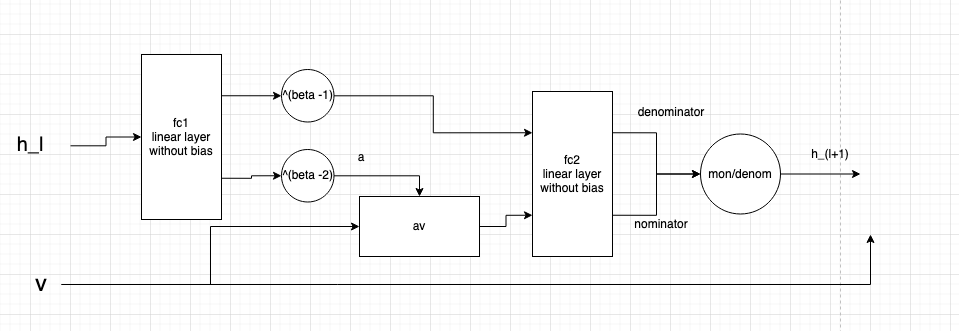

fc1 is a fully connected linear layer, as follow: 

*   $x \in \mathbb{R^c}$ - input vector
*   $y \in \mathbb{R^f}$ - output vector
*   $W^{l}_1 \in \mathbb{R}^{f,c}$ - weights matrix
*   $W^{l}_1x^{l}_i = y^{l+1}_i$
*   we learn the $W^{l}_1$ matrix which is the weights of this layer.

fc2 is a fully connected linear layer, as follow: 

*   $x \in \mathbb{R^f}$ - input vector
*   $y \in \mathbb{R^c}$ - output vector
*   $W^{l}_2 \in \mathbb{R}^{c,f}$ - weights matrix
*   $W^{l}_2x^{l}_i = y^{l+1}_i$
*   we learn the $W^{l}_2$ matrix which is the weights of this layer.

In [0]:
class BetaNMFLayer(nn.Module):
    def __init__(self, beta, comp, features):
        super(BetaNMFLayer, self).__init__()
        # an affine operation: y = Wx +b
        self.beta = beta
        self.fc1 = nn.Linear(comp, features, bias=False)  # WH
        self.fc2 = nn.Linear(features, comp, bias=False)  # W.t*

    def forward(self, y, x):
        wh = self.fc1(y)
        denominator = self.fc2(wh.pow(self.beta - 1))
        numerator = self.fc2(torch.mul(x, wh.pow(self.beta - 2)))
        denominator[denominator == 0] = EPSILON
        delta = torch.div(numerator, denominator)
        return torch.mul(delta, y)